In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


In [2]:
import os
import shutil
import json

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, NBEATSx, Informer, Autoformer, TFT
from neuralforecast.auto import AutoNBEATS, AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae, mse, mase
from functools import partial

from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

C:\Users\tacke\AppData\Local\Temp\ipykernel_36512\3273045409.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [54]:
TRAIN_SUBSAMPLE = True  # Trains a subsample of IDs to improve run speed
RETUNE = False  # if false, will use pre-trained hyperparameters when generating the AUTO NeuralForecast

In [4]:
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [5]:
train_df.head(2)

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5
0,2012-01-01 00:00:00,MAC000061,0.114,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
1,2012-01-01 00:30:00,MAC000061,0.113,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0


In [6]:
print("Total # of IDs Pre-Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Pre-Sampling:  150


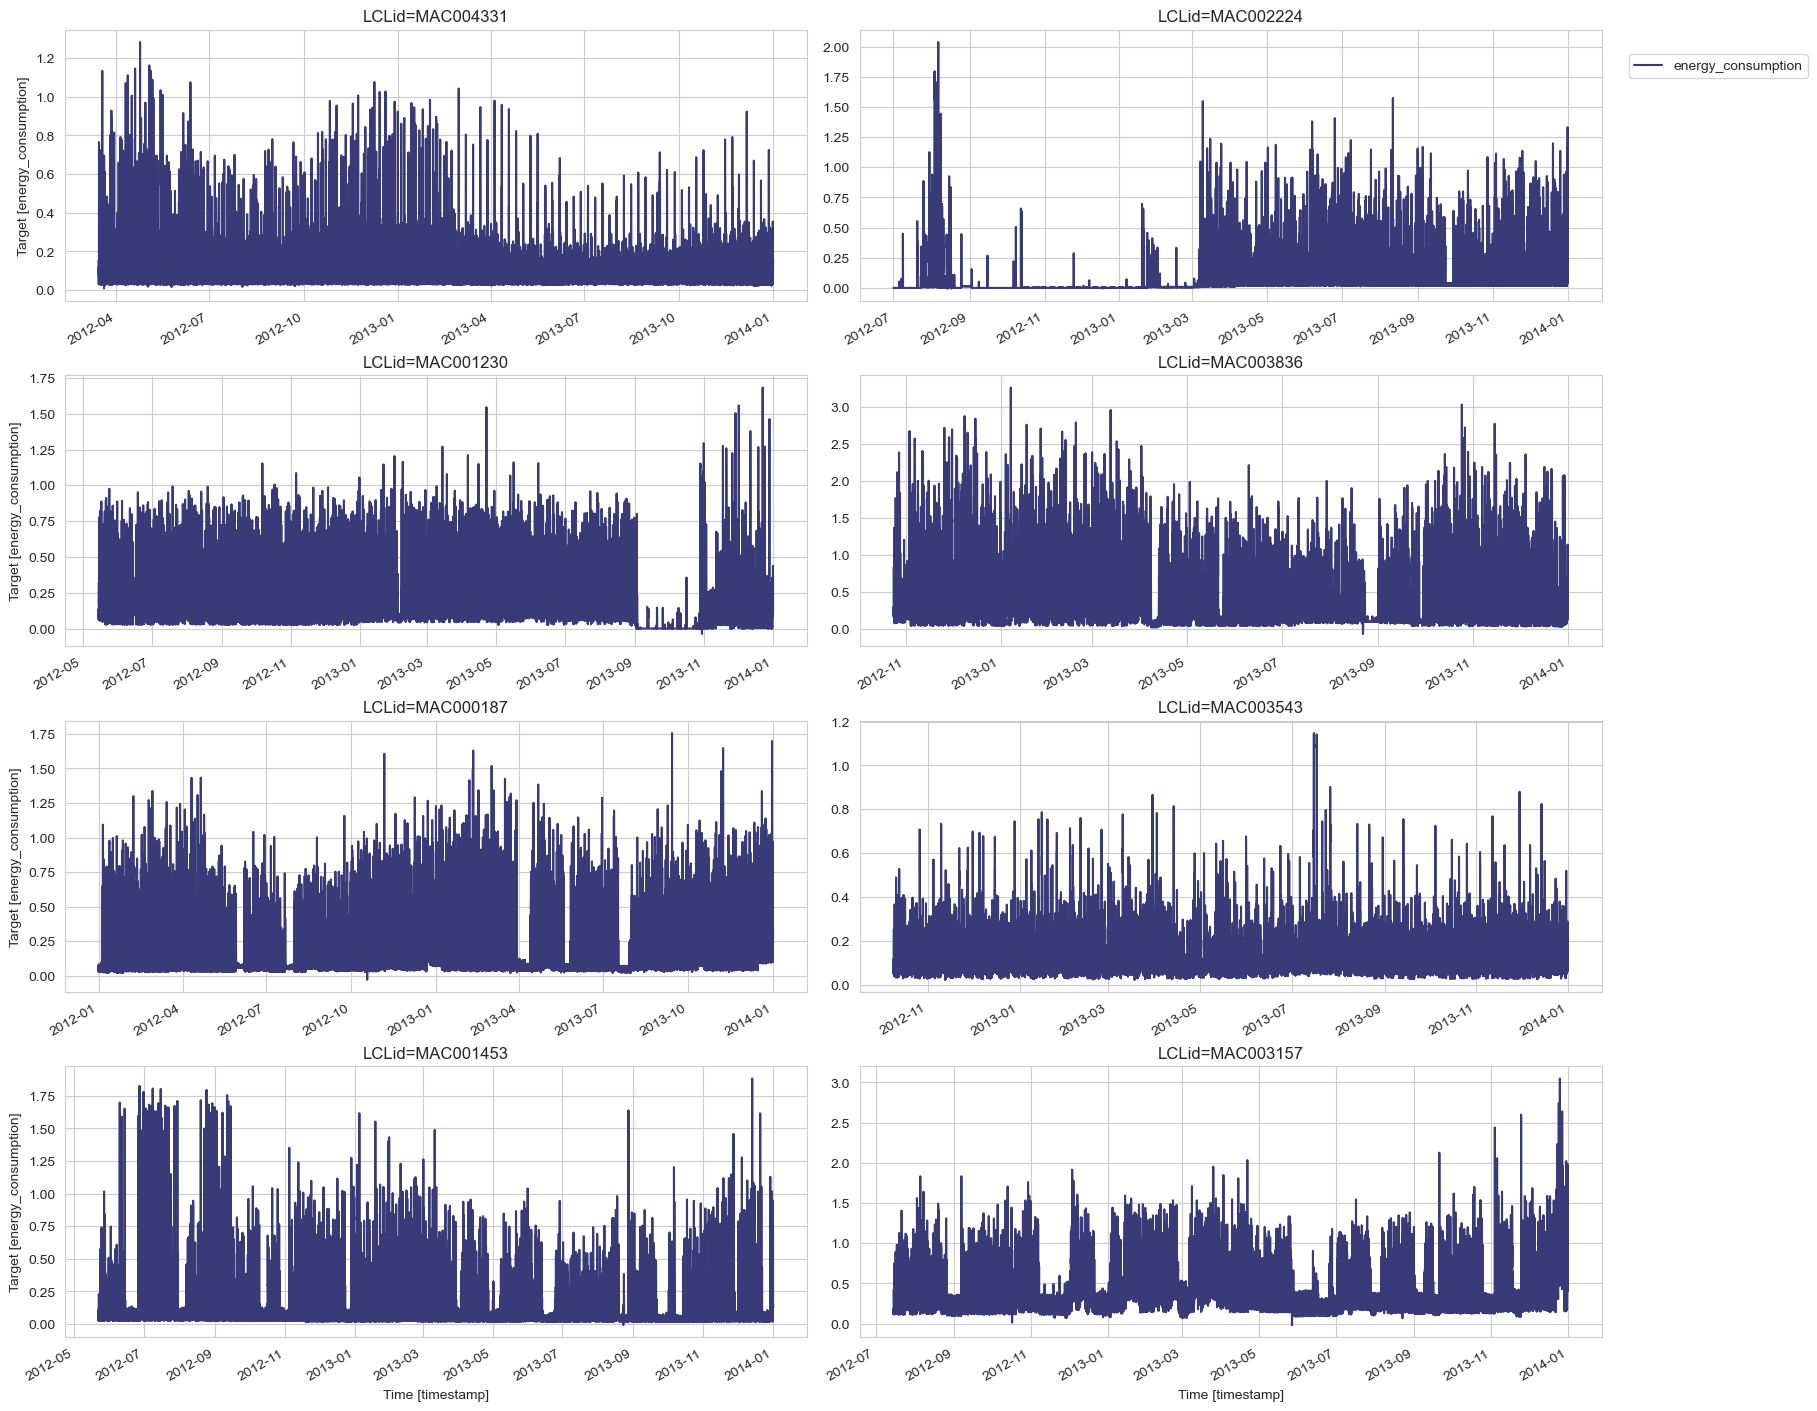

In [7]:
StatsForecast.plot(train_df, engine='matplotlib', id_col='LCLid',time_col= 'timestamp', target_col='energy_consumption')

In [8]:
# To run on smaller set of data for daster iteration.
if TRAIN_SUBSAMPLE:
    print("sub sampling")
    SAMPLE = 3
    sampled_LCLids = pd.Series(train_df.LCLid.unique().remove_unused_categories().categories).sample(SAMPLE, random_state=99).tolist()
    train_df = train_df.loc[train_df.LCLid.isin(sampled_LCLids)]
    test_df = test_df.loc[test_df.LCLid.isin(sampled_LCLids)]

sub sampling


In [9]:
print("Total # of IDs Post Sampling: ", len(train_df.LCLid.unique()))

Total # of IDs Post Sampling:  3


## Train, Validation, Test Set

In [11]:
print("Training Min Date: ", train_df.timestamp.min(), 
      "\nTraining Max Date: ", train_df.timestamp.max(), 
      "\nTesting Min Date: ", test_df.timestamp.min(),
      "\nTesting Max Date: ", test_df.timestamp.max()
)

Training Min Date:  2012-01-01 00:00:00 
Training Max Date:  2013-12-31 23:30:00 
Testing Min Date:  2014-01-01 00:00:00 
Testing Max Date:  2014-01-31 23:30:00


In [12]:
#Keeping 1 days aside as a validation set
cutoff = train_df.timestamp.max() - pd.Timedelta(1, "D")

validation_df = train_df[(train_df.timestamp>cutoff)].reset_index(drop=True) # validation prediction set
training_df = train_df[(train_df.timestamp<=cutoff)].reset_index(drop=True) # training set used for validation set

print(f"Train Max: {training_df.timestamp.max()} \nValidation Min: {validation_df.timestamp.min()} \nValidation Max: {validation_df.timestamp.max()}")
print(f"Validation Horizon: {len(validation_df.timestamp.unique())}")


Train Max: 2013-12-30 23:30:00 
Validation Min: 2013-12-31 00:00:00 
Validation Max: 2013-12-31 23:30:00
Validation Horizon: 48


##### Define Validation model parameters

In [13]:
h = 48
max_steps = 2

## Training NBEATS Model

In [14]:
h = 48
max_steps = 2

models_initial = [NBEATS(h=h,  input_size = 48*7,              
                max_steps=max_steps)]

models_initial = NeuralForecast(models=models_initial, freq='30min')
models_initial.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

Seed set to 1
c:\Users\tacke\anaconda3\envs\modern_ts_2E_new\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.2 M 
-----------------------------------------------
3.2 M     Trainable params
37.2 K    Non-trainable params
3.2 M     Total params
12.861    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=2` reached.


In [15]:
# Get Predictions for validation
pred_df =  models_initial.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df.merge(validation_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\tacke\anaconda3\envs\modern_ts_2E_new\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,LCLid,timestamp,NBEATS,energy_consumption
0,MAC000193,2013-12-31 00:00:00,0.330852,0.048
1,MAC000193,2013-12-31 00:30:00,0.504192,0.005
2,MAC000193,2013-12-31 01:00:00,0.661179,0.025
3,MAC000193,2013-12-31 01:30:00,0.607103,0.033
4,MAC000193,2013-12-31 02:00:00,0.509863,0.004


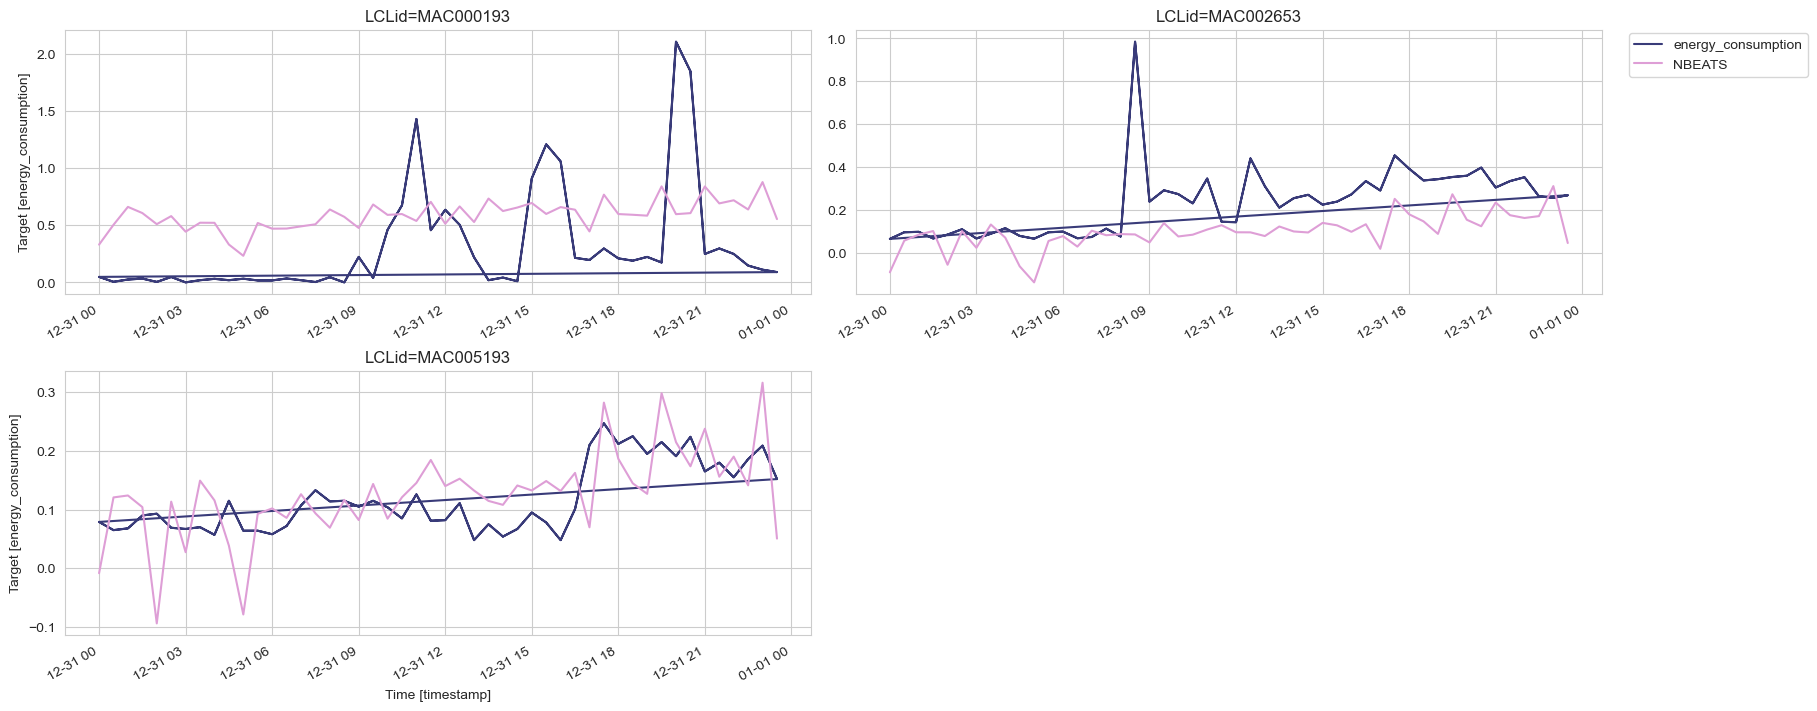

In [16]:
#visualize results
StatsForecast.plot(validation_df[['LCLid','timestamp','energy_consumption']], 
                   pred_df, engine='matplotlib', 
                   id_col='LCLid',
                   time_col= 'timestamp', 
                   target_col='energy_consumption',
                   models=['NBEATS'])

#### Evaluate NBEATS forecast

In [17]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
nbeats_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
nbeats_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [18]:
nbeats_metrics_agg

,metric,NBEATS
0,rmse,0.273321
1,mae,0.230342
2,mse,0.116021
3,mase,1.873650


## NBEATS Tuned
Since hyperparameters are key to performance in Neural Networks, NIXTLA has made this search each through the incorporation of Auto forecast.
Each NeuralForecast model has an AUTO class which allow you to easily tune your hyperparameters.

Auto Forecast can time, you can load the pre-trained hyperparameters or choose to retune on your own.
Set ```RETUNE = True``` if you wish to retune.


In [71]:
# Define the file path
config_file_path = r'notebooks\Chapter16\saved_params_config\nbeats_best_config.json'
with open(config_file_path, 'r') as config_file:
    loaded_config = json.load(config_file)
print(loaded_config)

{'max_steps': 30, 'input_size': 48, 'learning_rate': 0.010240621651367653, 'scaler_type': 'robust', 'batch_size': 256}


In [73]:
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch

nbeats_config = {
    "max_steps": 30,  # This parameter can be adjusted if needed
    #"input_size": 48*7*2,  # Size of input window
    "input_size": tune.choice([h,h*7,h*7*2,h*7*3]),
    "learning_rate": tune.loguniform(1e-2, 1e-1),  # Initial learning rate
    "scaler_type": tune.choice(["minmax", "robust", "standard"]),
    #"dropout_prob_theta":tune.uniform(0, .1),
    "batch_size": tune.choice([32, 64, 128, 256])    
}

if RETUNE == True:
    models = [AutoNBEATS(h=h, 
                     config = nbeats_config,
                     search_alg = HyperOptSearch(),
                     backend = 'ray',
                     num_samples = 30)]

else:
    models = [AutoNBEATS(h=h, 
                    config = loaded_config,
                    search_alg = None,
                    backend = 'ray')]


model = NeuralForecast(models=models, freq='30min')
model.fit(training_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption', verbose = True)

2024-08-03 16:28:03,504	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/tacke/ray_results/_train_tune_2024-08-03_16-23-57' in 0.0410s.
Seed set to 1
c:\Users\tacke\anaconda3\envs\modern_ts_2E_new\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.6 M 
-----------------------------------------------
2.6 M     Trainable params
9.3 K     Non-trainable params
2.6 M     Total params
10.389    Total estimated model params size (M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=30` reached.


The results of the tuning can then be viewed by running the below.

In [69]:
nbeats_best_config = model.models[0].results.get_best_result().config

# Remove specific keys using the pop method and then saving so we can extract parameters later
nbeats_best_config.pop("loss", None)
nbeats_best_config.pop("valid_loss", None)
nbeats_best_config.pop("h", None)

# Save the filtered configuration to a JSON file
with open(config_file_path, 'w') as config_file:
    json.dump(nbeats_best_config, config_file, indent=4)

print("Best configuration as string:")
print(nbeats_best_config)

Best configuration as string:
{'max_steps': 30, 'input_size': 48, 'learning_rate': 0.010240621651367653, 'scaler_type': 'robust', 'batch_size': 256}


In [22]:
results = model.models[0].results.get_dataframe()
results[['loss', 'train_loss', 'timestamp', 
       'training_iteration', 
        'config/max_steps', 'config/input_size',
       'config/learning_rate', 'config/h', 'config/loss',
       ]].head(2)

,loss,train_loss,timestamp,training_iteration,config/max_steps,config/input_size,config/learning_rate,config/h,config/loss
0,3.935471e+13,1.216538e+15,1722715585,1,30,1008,0.086527,48,MAE()
1,1.130974e+09,8.572814e+09,1722715677,1,30,1008,0.039467,48,MAE()


In [23]:
pred_df_autoNBEATS =  model.predict(futr_df=validation_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df = pred_df_autoNBEATS.merge(pred_df[['LCLid','timestamp','energy_consumption','NBEATS']], on=['LCLid','timestamp'], how='left')
pred_df.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\tacke\anaconda3\envs\modern_ts_2E_new\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,LCLid,timestamp,AutoNBEATS,energy_consumption,NBEATS
0,MAC000193,2013-12-31 00:00:00,0.050758,0.048,0.330852
1,MAC000193,2013-12-31 00:30:00,0.104901,0.005,0.504192
2,MAC000193,2013-12-31 01:00:00,0.054904,0.025,0.661179
3,MAC000193,2013-12-31 01:30:00,0.045335,0.033,0.607103
4,MAC000193,2013-12-31 02:00:00,0.031662,0.004,0.509863


In [24]:
fcst_mase = partial(mase, seasonality=48)

autoNBEATS_metrics = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

autoNBEATS_metrics_agg = evaluate(pred_df, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [25]:
autoNBEATS_metrics_agg

,metric,AutoNBEATS,NBEATS
0,rmse,0.245689,0.273321
1,mae,0.137439,0.230342
2,mse,0.100905,0.116021
3,mase,1.184722,1.873650


## Interpretability
NBEATS also allows for decomposing the time series in to harmonic, trend, and seasonality.

In [90]:
from neuralforecast.tsdataset import TimeSeriesDataset

model_interpretable = models_initial.models[0]

dataset, *_ = TimeSeriesDataset.from_df(df = training_df, id_col='LCLid',time_col='timestamp',target_col='energy_consumption')
y_hat = model_interpretable.decompose(dataset=dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

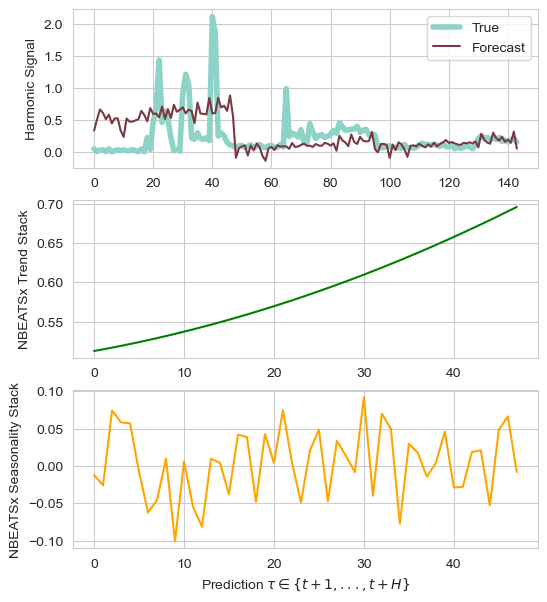

In [89]:
fig, ax = plt.subplots(3, 1, figsize=(6, 7))

ax[0].plot(validation_df['energy_consumption'].values, label='True', linewidth=4)
ax[0].plot(y_hat.sum(axis=1).flatten(), label='Forecast', color="#7B3841")
ax[0].legend()
ax[0].set_ylabel('Harmonic Signal')

ax[1].plot(y_hat[0,2]+y_hat[0,0], label='stack1', color="green")
ax[1].set_ylabel('NBEATSx Trend Stack')

ax[2].plot(y_hat[0,1], label='stack2', color="orange")
ax[2].set_ylabel('NBEATSx Seasonality Stack')
ax[2].set_xlabel(r'Prediction $\tau \in \{t+1,..., t+H\}$')
plt.show()

## TEST SET Predictions

In [75]:
h_test = len(test_df.timestamp.unique()) # horizon of the test set

models_test = [AutoNBEATS(h=h_test, 
                    config = loaded_config,
                    search_alg = None,
                    backend = 'ray')]

models_test = NeuralForecast(models=models_test, freq='30min')
models_test.fit(train_df[['LCLid','timestamp','energy_consumption']], id_col = 'LCLid',time_col = 'timestamp',target_col='energy_consumption')

2024-08-03 16:42:38,503	WARNING util.py:201 -- The `on_step_begin` operation took 0.687 s, which may be a performance bottleneck.
2024-08-03 16:52:26,445	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/tacke/ray_results/_train_tune_2024-08-03_16-41-17' in 0.0330s.
Seed set to 1
c:\Users\tacke\anaconda3\envs\modern_ts_2E_new\Lib\site-packages\neuralforecast\common\_base_model.py:345: UserWarning: val_check_steps is greater than max_steps, setting val_check_steps to max_steps.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 10.9 M
---------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=30` reached.


In [79]:
pred_df_test =  models_test.predict(futr_df=test_df[['LCLid','timestamp','energy_consumption']]).reset_index()
pred_df_test = pred_df_test.merge(test_df[['LCLid','timestamp','energy_consumption']], on=['LCLid','timestamp'], how='left')
pred_df_test.head()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\tacke\anaconda3\envs\modern_ts_2E_new\Lib\site-packages\neuralforecast\core.py:209: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,LCLid,timestamp,AutoNBEATS,energy_consumption
0,MAC000193,2014-01-01 00:00:00,0.028168,0.223
1,MAC000193,2014-01-01 00:30:00,0.043858,0.274
2,MAC000193,2014-01-01 01:00:00,0.032883,0.308
3,MAC000193,2014-01-01 01:30:00,0.049529,0.279
4,MAC000193,2014-01-01 02:00:00,0.040181,0.000


In [80]:
fcst_mase = partial(mase, seasonality=48)

# Get metrics for individual LCLid's
nbeats_metrics_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption'
        )

# Get aggregated metrics for across all LCLid's by model
nbeats_metrics_agg_test = evaluate(pred_df_test, 
        metrics=[rmse, mae, mse, fcst_mase],  
        train_df = train_df[['timestamp', 'LCLid', 'energy_consumption']],      
        id_col = 'LCLid',
        time_col = 'timestamp',
        target_col = 'energy_consumption',
        agg_fn='mean'
        )

In [81]:
nbeats_metrics_agg_test

,metric,AutoNBEATS
0,rmse,0.256234
1,mae,0.166238
2,mse,0.104787
3,mase,1.420183
